# Variable $R_{t}$ Sampler

Mixed sampling routine for sythentic model data with variable $R_{t}$. This is a vector form (with a difference value for each element of the time series), and will be inferred alongside the true series values $I_{t}$.

A periodic reporting trend is achieved by assigning each weekday a fixed reporting bias $\alpha_{w[t]}$, which does not vary over time and is independant of other days. This scales the true case/death number on each day to give the recorded count.

## Fixed Bias Formulation

Observed (biased) case values are sampled from a Poisson distribution: $C_{t} \sim Po(\alpha_{w[t]} I_{t})$, where the true cases are still given by the renewal equation $I_{t} \sim Po(R_{t} \Lambda_{t})$. Note that this model is not mechanistic, and there is no requirement imposed that the number of cases is conserved across the reporting process (i.e. that valules of $\alpha_{i}$ average to unity), although the inference process tends not to deviate far from this.

The parameters are updated in three steps. 

**Firstly** the reproduction value $R_{t}$ is sampled for every timestep $t$. We use a sliding window to assume $R_{t}$ has been constant for the previous 7 days. This gives the following conditional probability (derived in the next section), based on the prior $Gamma(a_{R}, b_{R})$:

$$
P(R_{t} | I_{t}) \propto Gamma \Biggl(a_{R} + \sum_{t'=t-6}^{t} I_{t'}, b_{R} + \sum_{t'=t-6}^{t}\Lambda_{t'} \Biggr) 
$$


In the first seven days, we will simply use the complete history without worrying that there is less information available.

**Secondly** each time step $I_{t}$ is sampled independently from the following distribution:

$$
P(I_{t} | C_{t}, \alpha_{i}, R_{t}) =  Po(I_{t} | R_{t} \Lambda_{t}) \times Po(C_{t} | \alpha_{i}I_{t})
$$

for discrete values of $I_{t}$, and where the $R_{t}$ estimated in the prior step is used.

N.B For $t=0$, $\Lambda_{t}$ is not defined, and therefore we take $\Lambda_{0} = C_{0}\alpha_{0}$ as an estimate of the seed cases instead during inference.

**Finally**, $\alpha_{i}$ are updated using Gibbs sampling from the following conditional probability:

$$
P(\alpha_{i} | I_{t} , C_{t}) \sim Gamma \left(a_{\alpha} + \sum_{t=i}^{n}C_{t}, b_{\alpha} + \sum_{t=i}^{n}I_{t} \right)
$$

(based on a gamma prior $Gamma(\alpha_{i} | a_{\alpha}, b_{\alpha})$ - see `constant_R_sampler.ipynb` for details of this derivation).






## Sampling the $R_{t}$ values

We use a sliding window to assume R_{t} has been constant for the previous 7 days, and compute the probability of a given $R_{t}$ value based on data from this period. This gives a conditional posterior distribution of the following form:

$$
P(R_{t} | I_{t}) = \prod_{t'=max(0, t-6)}^{t}\biggl[ P(I_{t'} | R_{t}) \biggr] P(R_{t})
$$

where we have taken a product over the previous seven days. Note that $R_{t}$ is still used for terms where $t' < t$ (instead of using other parameter values $R_{t-1}$ etc), as we have assumed that $R_{t}$ is constant over this period.

In the first seven days, we will use the complete history without worrying that there is less information available. For notational simplicity however, I will assume the summation begins at $t-6$ in all subsequent steps.

Based on the Poisson form of $P(I_{t'} | R_{t})$, we choose a conjugate gamma prior $Gamma(R_{t} | a_{R}, b_{R})$ for $R_{t}$:

$$
P(R_{t} | I_{t}) = \prod_{t'=t-6}^{t}\biggl[ Po(I_{t'} | R_{t} \Lambda_{t'}) \biggr] \times Gamma(R_{t} | a_{R}, b_{R})
$$

which we may write explicitly as :

$$
P(R_{t} | I_{t}) = \prod_{t'=t-6}^{t}\biggl[(R_{t}\Lambda_{t'})^{I_{t'}} \frac{e^{-R_{t}\Lambda_{t'}}}{I_{t'}!}  \biggr] \times R_{t}^{a_{R}-1} e^{-b_{R} R_{t}} \frac{b_{R}^{a_{R}}}{\Gamma(a_{R})}
$$

While the factorial $I_{t'}!$ is given by another parameter value, it is independant of $R_{t}$, and so may be neglected when formulating a distribution to sample from. Similarly, we may remove the multiplicative constant $\prod_{t'=t-6}^{t}\Lambda_{t'}^{I_{t'}}$. Simplifying the product we obtain:


$$
P(R_{t} | I_{t}) = \biggl[R_{t}^{\sum_{t'=t-6}^{t}I_{t'}} e^{-R_{t}\sum_{t'=t-6}^{t}\Lambda_{t'}} \biggr] \times R_{t}^{a_{R}-1} e^{-b_{R} R_{t}} \frac{b_{R}^{a_{R}}}{\Gamma(a_{R})}
$$

Combining like terms from the Poisson and Gamma distributions, and neglecting the constant terms in the Gamma distribution, we arrive at:


$$
P(R_{t} | I_{t}) \propto  R_{t}^{\sum_{t'=t-6}^{t}[I_{t'}] + a_{R}-1} \times e^{-R_{t}(\sum_{t'=t-6}^{t}[\Lambda_{t'}] + b_{R})}
$$


which we may write in the form of a Gamma distribution:


$$
P(R_{t} | I_{t}) \propto Gamma \Biggl(a_{R} + \sum_{t'=t-6}^{t} I_{t'}, b_{R} + \sum_{t'=t-6}^{t}\Lambda_{t'} \Biggr) 
$$





## Synthetic Data Generation

Here we use a renewal model to generate synthetic data, which we will subsequently perform inference on.

In [2]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from synthetic_data import RenewalModel, Reporter

In [3]:
# Simulate Renewal Model
time_steps = 100; N_0 = 100; seed=41; R0_diff = 0.2
start_date = '01/01/2020'; bias_method = 'poisson'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))
images_path = "synthetic_inference/stepped_R/"

np.random.seed(seed)
model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list)

100%|██████████| 100/100 [00:00<00:00, 152188.10it/s]


In [4]:
# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

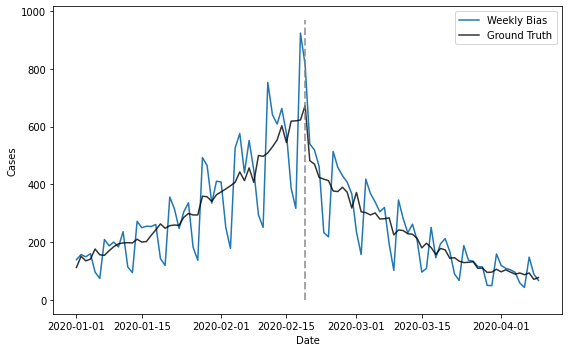

In [5]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
plt.vlines(x=mid_date, ymin=0, ymax=plt.gca().get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biased_data_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_seed_{seed}.png")

## Bayesian Inference

In [6]:
from sampling_methods import GibbsParameter, MixedSampler
from periodic_model import truth_parameter, poisson_bias_parameter, rt_parameter, single_r_parameter, constant_r_parameter

In [6]:
I_data = list(bias_df['Confirmed'])

params = {'bias_prior_alpha': 1, 'bias_prior_beta': 1,
          'rt_prior_alpha': 1, 'rt_prior_beta': 1}  # Gamma dist

params['serial_interval'] = RenewalModel(R0=None).serial_interval
params['Rt_window'] = 7  # Assume it is constant for 7 days

for i, val in enumerate(I_data):  # Observed cases - not a Parameter
    params[("data_" + str(i))] = val

data_initial_guess = sum(I_data)/len(I_data)  # Constant initial value
for i in range(0, len(I_data)):  # Ground truth data
    params[("truth_" + str(i))] = truth_parameter(data_initial_guess, index=i, sampling_freq = 200)

for i in range(7):  # Weekday bias parameters
    params[("bias_" + str(i))] = poisson_bias_parameter(value=1, index=i)

for i in range(0, len(I_data)):  # Reproductive number values
    params[("R_" + str(i))] = rt_parameter(value=1, index=i)
# R_change = int(time_steps / 2)
# params["R_0"] = constant_r_parameter(value=1.2, start=0, end=R_change)
# params["R_" + str(R_change)] = constant_r_parameter(value=0.8, start=R_change, end=time_steps)

step_num = int(1e5)
sampler = MixedSampler(params=params)

first_row = {key: value for key, value in params.items() if isinstance(value, GibbsParameter)}
initial_values = pd.DataFrame.from_dict(first_row, orient='index').T
output = sampler.sampling_routine(step_num=step_num, sample_burnin=0)
output.index += 1; output = pd.concat([initial_values, output])

filename = f"synth_inference_T_{bias_method}_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.csv"
output.to_csv('../data/outputs/stepped_R/' + filename)

100%|██████████| 100000/100000 [1:12:37<00:00, 22.95it/s]


In [7]:
# Read in old dataset

output = pd.read_csv("../data/outputs/stepped_R/normalised_bias/synth_inference_T_poisson_100_N0_100_R0diff_0.2_It_100000_seed_41.csv")
bias_method = 'poisson'; time_steps = 100; N_0 = 100; R0_diff = 0.2; step_num = 100000; seed = 41
if 'R_t' in output.columns:  # Backward compatibility
    output['R_0'] = output['R_t']

R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))
np.random.seed(41); model = RenewalModel(R0=None); model.simulate(T=time_steps, N_0=N_0, R_0=R0_list)

rep = Reporter(model.case_data, start_date=start_date)  
truth_df = rep.unbiased_report(); bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

images_path = "synthetic_inference/stepped_R/normalised_bias/"

100%|██████████| 100/100 [00:00<00:00, 167571.07it/s]


Mean bias values: [0.5, 1.5, 1.3, 1.0, 1.1, 1.0, 0.6]
True bias values: [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]


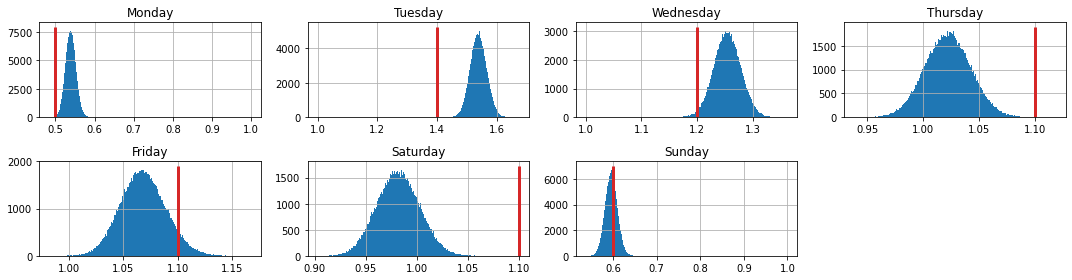

In [8]:
start_index = datetime.datetime.strptime(start_date, "%d/%m/%Y").weekday()
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=200, figsize=(15, 4), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
    histos.flatten()[i].vlines(x=bias[i], ymin=0, ymax=histos.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
plt.gcf().patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.tight_layout()
# plt.savefig(f"../images/{images_path}"
#             + f"biases_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seeds_{seed}.png")

print("Mean bias values: " + str(output_bias))
print(f"True bias values: {bias}")

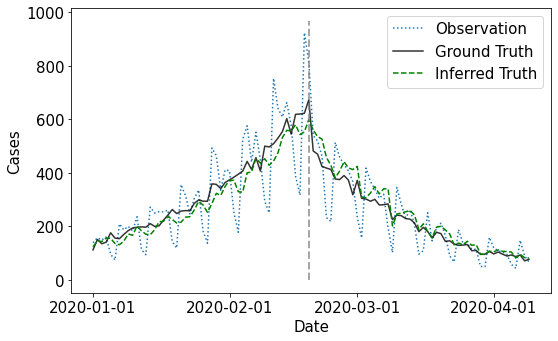

In [9]:
plt.rcParams['font.size'] = '15'
predicted_truth = []  

for index in range(0, time_steps):
    predicted_truth.append(np.mean(output['truth_' + str(index)]))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=ax, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=ax, color='black', label = 'Ground Truth', alpha=0.8)
ax.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')

mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
ax.vlines(x=mid_date, ymin=0, ymax=ax.get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
ax.set_xticks(ax.get_xticks()[::2]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.tight_layout()
# plt.savefig(f"../images/{images_path}"
#             + f"biased_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

IndexError: list index out of range

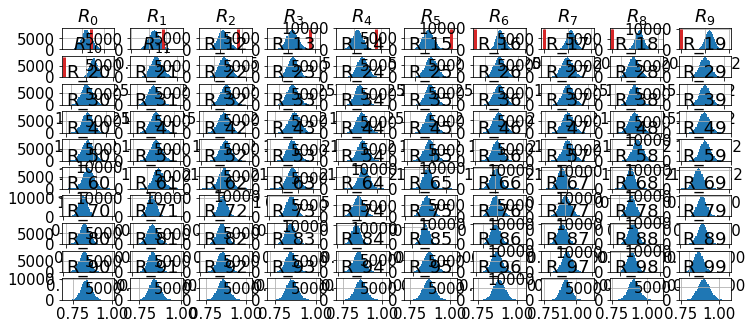

In [10]:
axs = output.hist([name for name in output.columns if name.startswith('R_')], bins=40, figsize=(12, 5));

for i, ax in enumerate(axs.flatten()):
    ax.set_title("$R_{" + str(ax.get_title()[2:]) + "}$")
    ax.vlines(x=R0_list[int((len(R0_list) - 1) * i / len(axs))], 
              ymin=0, ymax=ax.get_ylim()[1], color='tab:red', linewidth=3)

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(f"../images/{images_path}"
#                 + f"Rt_hist_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

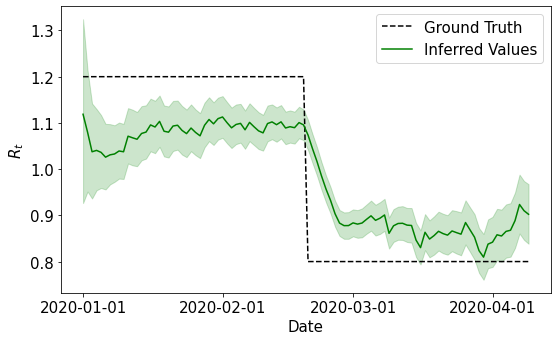

In [11]:
plt.rcParams['font.size'] = '15'; interval_range = 90
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


if ('R_1' in output.columns):
    for index in range(0, time_steps):
        predicted_R.append(np.mean(output['R_' + str(index)]))
        upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
        lower_R.append(np.percentile(output['R_' + str(index)], percentile))

    # Plot bias in data
    fig, ax = plt.subplots(1, figsize=(8,5))

    ax.plot(truth_df['Date'], R0_list, color='black', label = 'Ground Truth', linestyle = 'dashed')
    ax.plot(truth_df['Date'], predicted_R, color='green', label = 'Inferred Values')
    ax.fill_between(truth_df['Date'], lower_R, upper_R, color = 'green', alpha=0.2)

    ax.set_xticks(ax.get_xticks()[::2]);
    fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
    plt.xlabel("Date"); plt.ylabel("$R_{t}$")
    plt.legend(); plt.tight_layout()
    # plt.savefig(f"../images/{images_path}"
    #             + f"Rt_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

## Convergence Speed

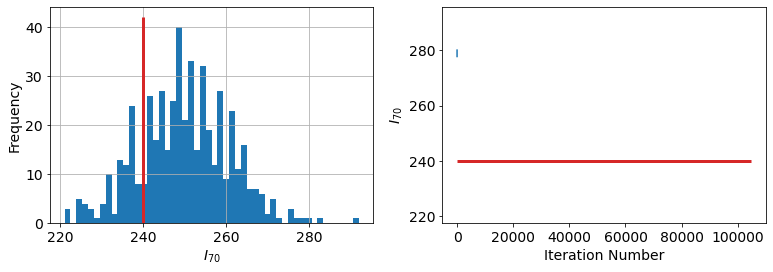

In [12]:
t = 70; I_x = 'truth_' + str(t)
value = truth_df['Confirmed'][t]; R_name = 'I_{'+ str(t) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(11,4))

histo = output.hist(I_x, ax=axs[0], bins=50)
axs[0].vlines(x=value, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
axs[0].set_xlabel(f'${R_name}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        chain_df = output[(output['Chain']==chain) & (output[I_x].notna())]
        axs[1].plot(chain_df.index % len(output.index[output['Chain']==chain]), chain_df[I_x])
        
else:
    axs[1].plot(output.index, output[I_x])
axs[1].hlines(y=value, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(f'${R_name}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(f"../images/{images_path}"
#             + f"{I_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

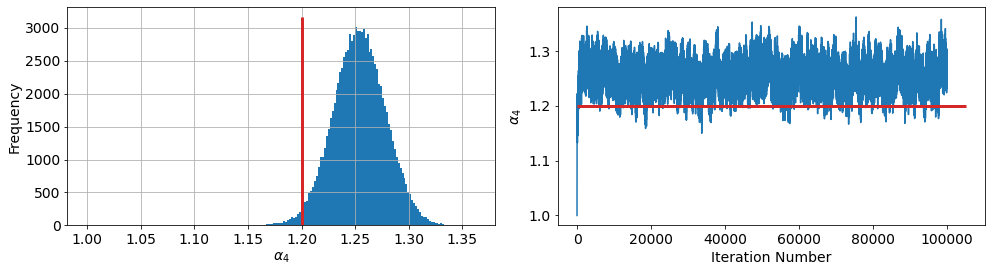

In [13]:
i = 0; bias_x = 'bias_' + str(i)
value = bias[i]; bias_name = 'alpha{' + str(i) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(14,4))

histo = output.hist(bias_x, ax=axs[0], bins=200)
axs[0].vlines(x=1.2, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
axs[0].set_xlabel(r'$\alpha_{4}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        index = output.index[output['Chain']==chain]
        # axs[1].plot(index % len(index), output[bias_x][output['Chain']==chain])
        axs[1].plot((pd.Series([x for x in range(len(index) + 1)]) % len(index + 1))[:-1],
                    (pd.concat([pd.Series([1.2]), output[bias_x][output['Chain']==chain]]))[:-1], alpha=0.7)
else:
    axs[1].plot(output.index, output[bias_x])
axs[1].hlines(y=1.2, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(r'$\alpha_{4}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(f"../images/{images_path}"
#             + f"{bias_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

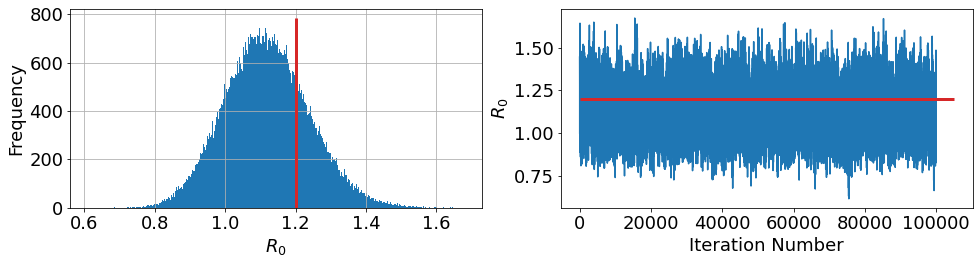

In [14]:
R_x = 'R_0'; value = 1 + R0_diff; R_name = 'R_{0}'

if (R_x in output.columns):
    plt.rcParams['font.size'] = '18'
    fig, axs = plt.subplots(1, 2, figsize=(14,4))

    histo = output.hist(R_x, ax=axs[0], bins=500)
    axs[0].vlines(x=value, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
    axs[0].set_xlabel(f'${R_name}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

    if ('Chain' in output.columns):
        chains = output['Chain'].unique()
        for chain in chains:
            index = output.index[output['Chain']==chain]
            R_vals = output[R_x][output['Chain']==chain]
            axs[1].plot(index % len(index), R_vals, alpha = 0.6)
            # axs[1].plot(index % len(index), R_vals.rolling(int(2e4)).mean())
    else:
        axs[1].plot(output.index, output[R_x])
    axs[1].hlines(y=value, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
    axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(f'${R_name}$'); axs[0].set_title('');
    print

    plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
    # plt.savefig(f"../images/{images_path}"
    #             + f"{R_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

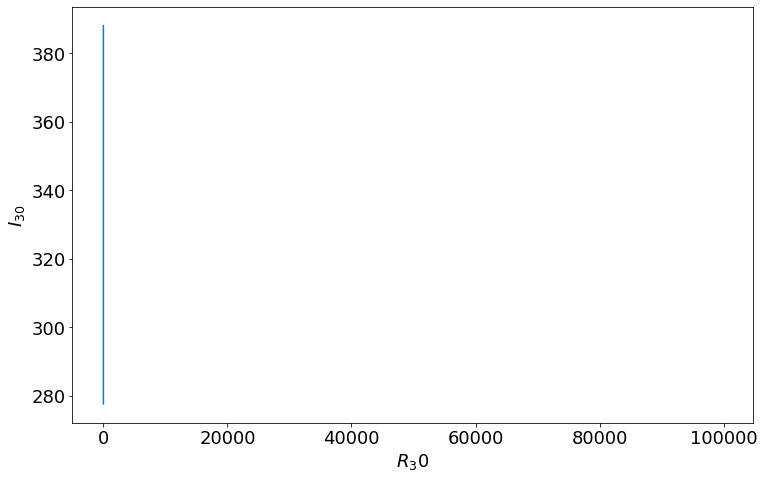

In [15]:
t = 30; I_x = 'truth_' + str(t); R_x = 'R_' + str(t)
value = truth_df['Confirmed'][t]; I_name = 'I_{'+ str(t) + '}'

plt.rcParams['font.size'] = '18'
fig, axs = plt.subplots(1, 1, figsize=(11,7))

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        chain_df = output[(output['Chain']==chain) & (output[I_x].notna())]
        axs.plot(chain_df[R_x], chain_df[I_x])
else:
    axs.plot(output.index, output[I_x])
axs.set_xlabel(f'$R_{30}$'); axs.set_ylabel(f'${I_name}$'); axs.set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(f"../images/{images_path}"
#             + f"{I_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

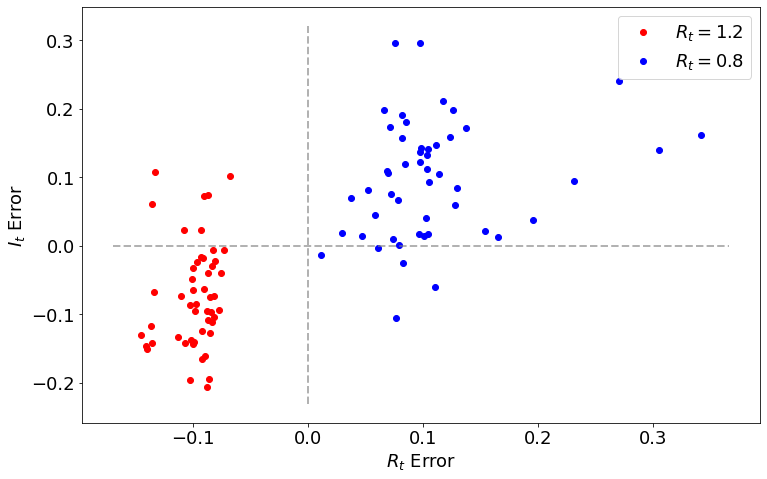

In [16]:
plt.rcParams['font.size'] = '18'
colors = ['r', 'b']; R_val = [1 + R0_diff, 1 - R0_diff]

if 'R_1' in output.columns:
    fig, axs = plt.subplots(1, 1, figsize=(11,7))
    for t in range(time_steps):
        if ('Chain' not in output.columns):
            output['Chain'] = 1
        chains = output['Chain'].unique()
        for chain in chains:
            index = output.index[output['Chain']==chain]
            axs.plot(
                np.mean((output['R_' + str(t)][output['Chain']==chain]) - R_val[t // int(time_steps /2)]) / R_val[t // int(time_steps /2)],
                # np.mean(output['bias_' + str(t % 7)][output['Chain']==chain]) - bias[(t + start_index) % 7],
                (np.mean(output['truth_' + str(t)][output['Chain']==chain]) - truth_df['Confirmed'][t]) / truth_df['Confirmed'][t],
                marker='o', color = colors[t // int(time_steps /2)], linestyle = '')

    axs.hlines(y=0, xmin=axs.get_xlim()[0], xmax=axs.get_xlim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.vlines(x=0, ymin=axs.get_ylim()[0], ymax=axs.get_ylim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.set_xlabel(r'$R_{t}$ Error'); axs.set_ylabel(r'$I_{t}$ Error'); axs.set_title('');
    axs.lines[1].set_label(r'$R_{t} = 1.2$'); axs.lines[-1].set_label(r'$R_{t} = 0.8$')

    plt.gcf().patch.set_facecolor('white'); plt.legend(); plt.tight_layout();
    # plt.savefig(f"../images/{images_path}"
    #             + f"error_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

## Inferred Timeseries Accuracy

This section contains methods to quantify the accuracy of the inferred timeseries, in comparison to both the biased timeseries, and a rolling 7 day average method (the government standard).

In [17]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

RMS Residual for Biased data: 98.42
RMS Residual for Rolling Average data: 43.25
RMS Residual for Bayesian Inference data: 36.13


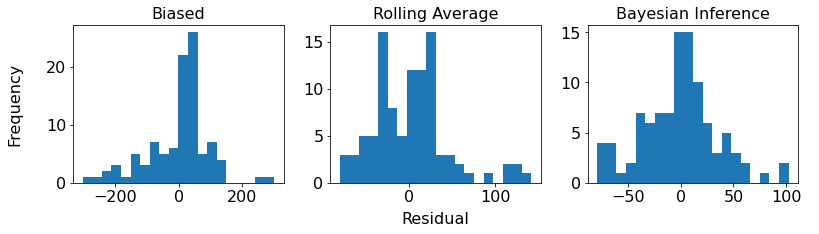

In [18]:
roll_ave_series = bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()
data_series = [bias_df['Confirmed'], roll_ave_series, predicted_truth]
labels = ['Biased', 'Rolling Average', 'Bayesian Inference']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    residual = data_series[i] - truth_df['Confirmed']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig(f"../images/{images_path}"
#             + f"series_residuals_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

Expected lag for Biased data: 0.08 days
Expected lag for Rolling Average data: 1.90 days
Expected lag for Bayesian Inference data: 1.47 days


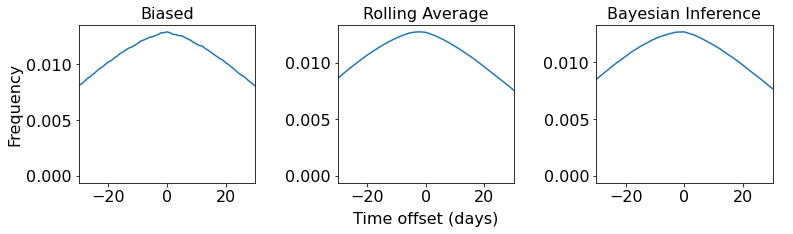

In [19]:
fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(truth_df['Confirmed'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(truth_df['Confirmed']) + 1, len(truth_df['Confirmed']))
    expected_lag = np.dot(t_values, cross_corr)
    
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  # Normalise by number of contributing elements from timeseries
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig(f"../images/{images_path}"
#             + f"series_crosscorr_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")